In [257]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, logm

In [258]:
SigX = np.array([[0, 1], [1, 0]])
SigY = np.array([[0, -1j], [1j, 0]])
SigZ = np.array([[1, 0], [0, -1]])
SigI = np.array([[1, 0], [0, 1]])

pauli_basis_2q = [
    np.kron(SigI, SigI),
    np.kron(SigI, SigX),
    np.kron(SigI, SigY),
    np.kron(SigI, SigZ),
    np.kron(SigX, SigI),
    np.kron(SigX, SigX),
    np.kron(SigX, SigY),
    np.kron(SigX, SigZ),
    np.kron(SigY, SigI),
    np.kron(SigY, SigX),
    np.kron(SigY, SigY),
    np.kron(SigY, SigZ),
    np.kron(SigZ, SigI),
    np.kron(SigZ, SigX),
    np.kron(SigZ, SigY),
    np.kron(SigZ, SigZ),
]

len(pauli_basis_2q)

ux1 = np.kron(expm(-1j * np.pi / 4 * SigX), SigI)
ux2 = np.kron(SigI, expm(-1j * np.pi / 4 * SigX))
uz1 = np.kron(expm(-1j * np.pi / 4 * SigZ), SigI)
uz2 = np.kron(SigI, expm(-1j * np.pi / 4 * SigZ))
uy1 = np.kron(expm(-1j * np.pi / 4 * SigY), SigI)
uy2 = np.kron(SigI, expm(-1j * np.pi / 4 * SigY))

In [314]:
def model_CZ(x):
    generator = np.zeros((4, 4), dtype=complex)
    generator += (np.pi/2)*(pauli_basis_2q[3] + pauli_basis_2q[12]) - np.pi/2*(pauli_basis_2q[15] + pauli_basis_2q[0])
    for i in range(15):
        generator += x[i]*pauli_basis_2q[i+1]
    return expm(-(1j/2)*generator)

In [315]:
def angular_difference(phi1, phi2):
    # returns the distance between two angles measured in radians 
    diff = phi2 - phi1
    return np.mod(diff + np.pi, 2*np.pi) - np.pi

In [316]:
from typing import Any

class UnitaryGateSetModel_CZOnly:
    def __init__(self):
        self.num_qubits = 2
        self.num_params = 15
        self.gate_names = ['CZ', 'X1', 'X2', 'Z1', 'Z2', 'Y1', 'Y2']
        self.hilbert_dims = 4
        self.cartan_basis = [
            np.diag([1, -1, 0, 0]), 
            np.diag([0, 1, -1, 0]),
            np.diag([0, 0, 1, -1]),
        ]

    def CZ(self, parameters):
        return model_CZ(parameters)
    
    def X1(self, parameters):
        return np.kron(expm(-1j * np.pi / 4 * SigX), SigI)
    
    def X2(self, parameters):
        return np.kron(SigI, expm(-1j * np.pi / 4 * SigX))
    
    def Z1(self, parameters):
        return np.kron(expm(-1j * np.pi / 4 * SigZ), SigI)
    
    def Z2(self, parameters):
        return np.kron(SigI, expm(-1j * np.pi / 4 * SigZ))
    
    def Y1(self, parameters):
        X1 = self.X1(parameters)
        Z1 = self.Z1(parameters)
        return Z1 @ Z1 @ Z1 @ X1 @ Z1 
    
    def Y2(self, parameters):
        X2 = self.X2(parameters)
        Z2 = self.Z2(parameters)
        return Z2 @ Z2 @ Z2 @ X2 @ Z2
    
    def gate(self, name, parameters):
        if name not in self.gate_names:
            raise ValueError(f"Gate {name} not found in the model")
        return getattr(self, name)(parameters)
    
    def target_gate(self, name):
        if name not in self.gate_names:
            raise ValueError(f"Gate {name} not found in the model")
        return getattr(self, name)(np.zeros(self.num_params))
    
    def compile_unitary(self, germ, parameters):
        u = np.eye(self.hilbert_dims)
        for gate_name in germ:
            u = self.gate(gate_name, parameters) @ u
        return u  
    
    def true_cartan_parameters(self, germ, params):
        unitary = self.compile_unitary(germ, params)
        log_unitary = logm(unitary)
        cparams = np.array( [np.trace(log_unitary @ basis) for basis in self.cartan_basis] )
        # check that parameters are imaginary
        assert np.allclose(np.real(cparams), 0)
        return np.imag(cparams)
    
    # def approx_cartan_parameters(self, germ, params):
    #     unitary = self.compile_unitary(germ, params)
    #     target_unitary = self.compile_unitary(germ, np.zeros(self.num_params))
    #     error_gen = logm(unitary @ target_unitary.conj().T)
    #     target_cartan_params = self.true_cartan_parameters(germ, np.zeros(self.num_params))
    #     cparams = np.array( [np.trace(error_gen @ basis) for basis in self.cartan_basis] )
    #     # check that parameters are imaginary
    #     assert np.allclose(np.real(cparams), 0)
    #     return np.imag(cparams) - target_cartan_params

    # def model_error(self, germ, params):
    #     return np.linalg.norm(angular_difference(self.true_cartan_parameters(germ, params), self.approx_cartan_parameters(germ, params)))
    

In [330]:
x = 0.01*np.random.randn(15)
model = UnitaryGateSetModel_CZOnly()
germ = ['CZ']
print(model.compile_unitary(germ, x))
print(model.true_cartan_parameters(germ, x))


[[ 9.99949804e-01+0.00227059j -6.81418625e-05+0.00645878j
   2.09560194e-03-0.00041571j  6.74762489e-03+0.00184873j]
 [ 1.08547052e-04+0.00642456j  9.99793182e-01-0.00712565j
  -1.42057106e-02-0.00730172j  4.01288222e-04+0.00813967j]
 [-2.01331541e-03-0.00032159j  1.42389840e-02-0.00734773j
   9.99833673e-01+0.00664171j -3.35567554e-03-0.00404458j]
 [ 6.80906961e-03-0.00185098j  3.22328949e-04-0.00801605j
  -3.42660938e-03+0.00413406j -9.99926911e-01+0.00178607j]]
[ 0.00938413 -0.01373899 -3.13303003]


In [331]:
class RPEDesign:
    def __init__(self, model, germs, depths):
        self.model = model
        self.germs = germs
        self.depths = depths
        self.num_params = model.num_params
        self.num_qubits = model.num_qubits
        self.hilbert_dims = model.hilbert_dims
        self.cartan_basis = model.cartan_basis
        self.gate_names = model.gate_names

        self.basis_transforms = {
            tuple(germ): self._calculate_basis_transform_at_target(germ) for germ in germs
        }

    def _calculate_basis_transform_at_target(self, germ):
        target_unitary = self.model.compile_unitary(germ, np.zeros(self.num_params))
        _, evecs = np.linalg.eig(target_unitary)
        return evecs 
    
    def inphase_prep(self, germ, subspace):
        a, b = subspace
        plus_ab = np.zeros(self.hilbert_dims, dtype=complex)
        plus_ab[a] = 1/np.sqrt(2)
        plus_ab[b] = 1/np.sqrt(2)
        return self.basis_transforms[tuple(germ)]@plus_ab  
    
    def quadrature_prep(self, germ, subspace):
        a, b = subspace
        plus_ab = np.zeros(self.hilbert_dims, dtype=complex)
        plus_ab[a] = 1/np.sqrt(2)
        plus_ab[b] = 1j/np.sqrt(2)
        return self.basis_transforms[tuple(germ)]@plus_ab
    
    def inphase_prob(self, germ, depth, params, subspace):
        u = self.model.compile_unitary(germ, params)
        u_d = np.linalg.matrix_power(u, depth)
        plus_ab = self.inphase_prep(germ, subspace)
        return np.abs(plus_ab.conj().T @ u_d @ plus_ab)**2
    
    def inphase_prob_series(self, germ, params, subspace):
        return np.array([self.inphase_prob(germ, depth, params, subspace) for depth in self.depths])
    
    def quadrature_prob(self, germ, depth, params, subspace):
        u = self.model.compile_unitary(germ, params)
        u_d = np.linalg.matrix_power(u, depth)
        quad_ab = self.quadrature_prep(germ, subspace)
        plus_ab = self.inphase_prep(germ, subspace)
        return np.abs(plus_ab.conj().T @ u_d @ quad_ab)**2
    
    def quadrature_prob_series(self, germ, params, subspace):
        return np.array([self.quadrature_prob(germ, depth, params, subspace) for depth in self.depths])
    
    def signal(self, germ, params, subspace):
        inphase_probs = self.inphase_prob_series(germ, params, subspace)
        quadrature_probs = self.quadrature_prob_series(germ, params, subspace)
        return (1 - 2*inphase_probs) + 1j*(1 - 2*quadrature_probs)
    





In [388]:
def plot_complex_signal_in_unit_circle(signal, ax=None, title=None):
    """Plots a complex signal in the unit circle
    Use a viridis color gradient to show the evolution of the signal, 
    the signal is plotted as points inside a solid circule of radius 1
    """
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.plot(np.cos(np.linspace(0, 2*np.pi, 100)), np.sin(np.linspace(0, 2*np.pi, 100)), color='black')
    ax.scatter(signal.real, signal.imag, c=np.linspace(0, 1, len(signal)), cmap='viridis')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_xlabel('Re')
    ax.set_ylabel('Im')
    if title is not None:
        ax.set_title(title)



In [389]:
germs = [['CZ'],
         ['CZ', 'Z1', 'Z1', 'Z2'], 
         ['CZ', 'X2', 'X2', 'X1'],
         ['Y2', 'Y2', 'X1', 'CZ'],
         ['X2', 'Y1', 'CZ', 'Y2'],
         ['CZ', 'X1', 'X1', 'Y2']]
depths = [i+1 for i in range(1000)]
edesign = RPEDesign(UnitaryGateSetModel_CZOnly(), germs, depths)

In [390]:
x = 0.1*np.random.randn(15) 
x

array([ 0.09070185, -0.05856781, -0.10540159,  0.03909609, -0.01668573,
        0.13155109, -0.09594733,  0.13200695,  0.08294663, -0.0282729 ,
       -0.18751184, -0.09942188,  0.02896599,  0.01652975, -0.0108644 ])

In [391]:
signal = edesign.signal(['CZ', 'Z1', 'Z1', 'Z2'], x, (1, 3))

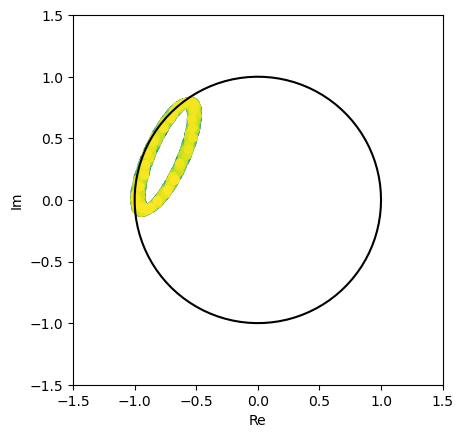

In [392]:
plot_complex_signal_in_unit_circle(signal)

In [406]:
def plot_cartan_signals(edesign, germ, params):
    fig, axs = plt.subplots(2, 3, figsize=(10, 5))
    subspace = (0, 1)
    signal = edesign.signal(germ, params, subspace)
    plot_complex_signal_in_unit_circle(signal, ax=axs[0, 0], title='(0,1)')

    subspace = (0, 2)
    signal = edesign.signal(germ, params, subspace)
    plot_complex_signal_in_unit_circle(signal, ax=axs[0, 1], title='(0,2)')

    subspace = (0, 3)
    signal = edesign.signal(germ, params, subspace)
    plot_complex_signal_in_unit_circle(signal, ax=axs[0, 2], title='(0,3)')

    subspace = (1, 2)
    signal = edesign.signal(germ, params, subspace)
    plot_complex_signal_in_unit_circle(signal, ax=axs[1, 0], title='(1,2)')

    subspace = (1, 3)
    signal = edesign.signal(germ, params, subspace)
    plot_complex_signal_in_unit_circle(signal, ax=axs[1, 1], title='(1,3)')

    subspace = (2, 3)
    signal = edesign.signal(germ, params, subspace)
    plot_complex_signal_in_unit_circle(signal, ax=axs[1, 2], title='(2,3)')
    

   

    # super title from germ
    plt.suptitle(f'{germ}')

     # tight layout
    plt.tight_layout()


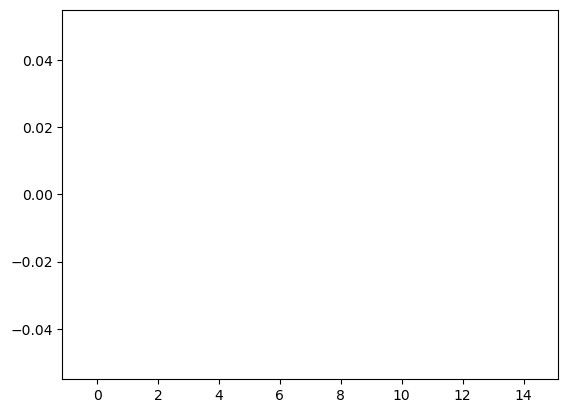

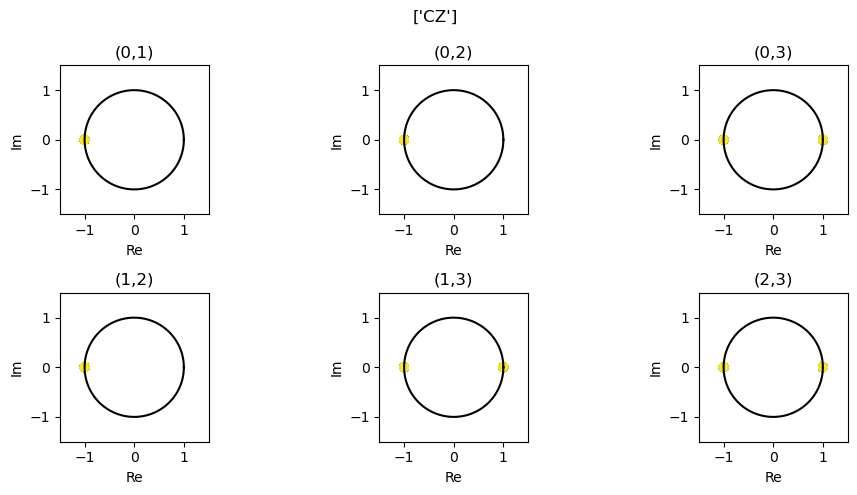

<Figure size 640x480 with 0 Axes>

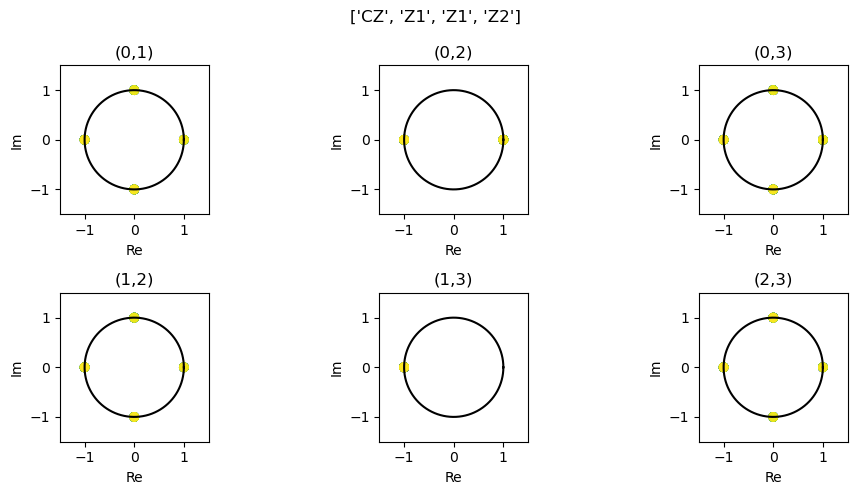

<Figure size 640x480 with 0 Axes>

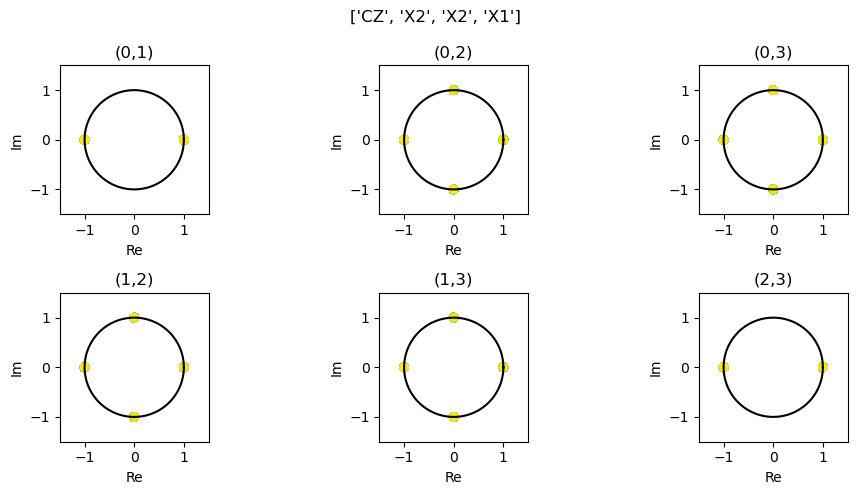

<Figure size 640x480 with 0 Axes>

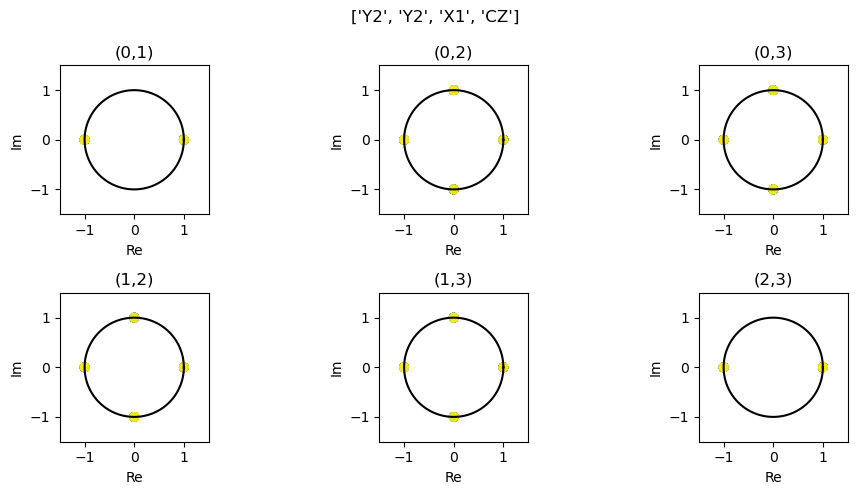

<Figure size 640x480 with 0 Axes>

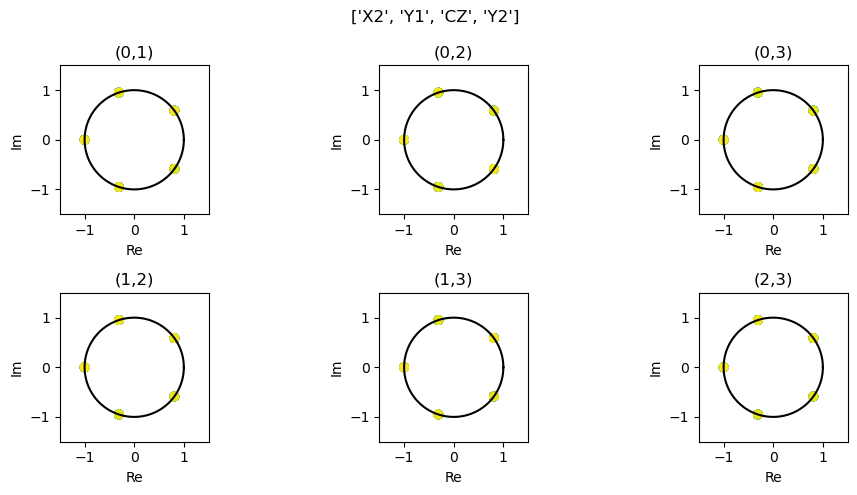

<Figure size 640x480 with 0 Axes>

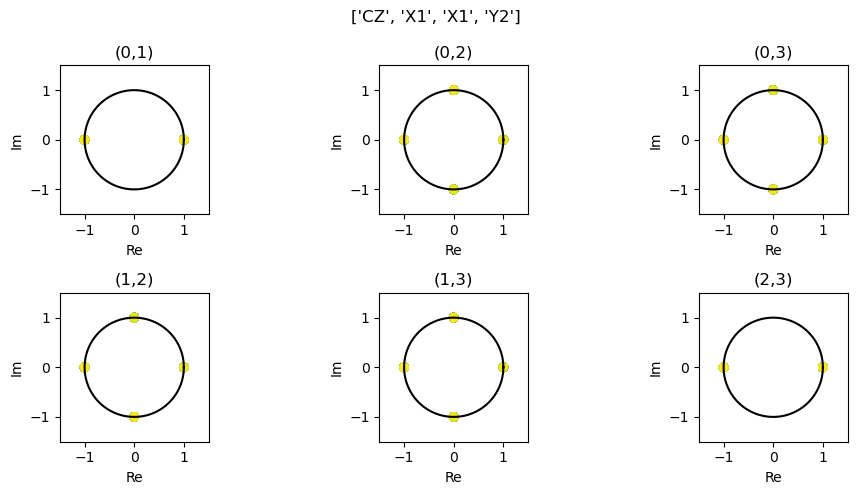

<Figure size 640x480 with 0 Axes>

In [416]:
# at target
germs = [['CZ'],
         ['CZ', 'Z1', 'Z1', 'Z2'], 
         ['CZ', 'X2', 'X2', 'X1'],
         ['Y2', 'Y2', 'X1', 'CZ'],
         ['X2', 'Y1', 'CZ', 'Y2'],
         ['CZ', 'X1', 'X1', 'Y2']]
depths = [i+1 for i in range(100)]
edesign = RPEDesign(UnitaryGateSetModel_CZOnly(), germs, depths)
x = 0.0*np.random.randn(15)

# bar plot x 
plt.bar(np.arange(15), x)


for germ in germs: 
    plot_cartan_signals(edesign, germ, x)
    plt.show()
    plt.figure()

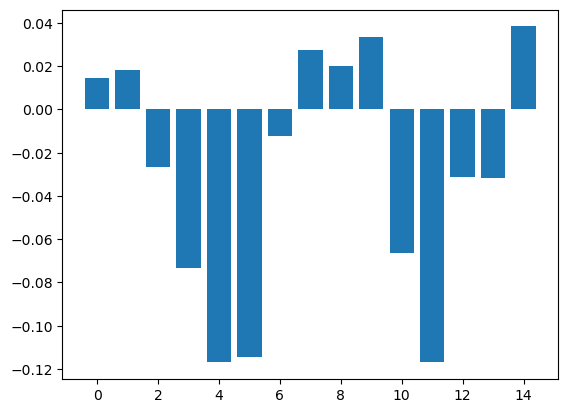

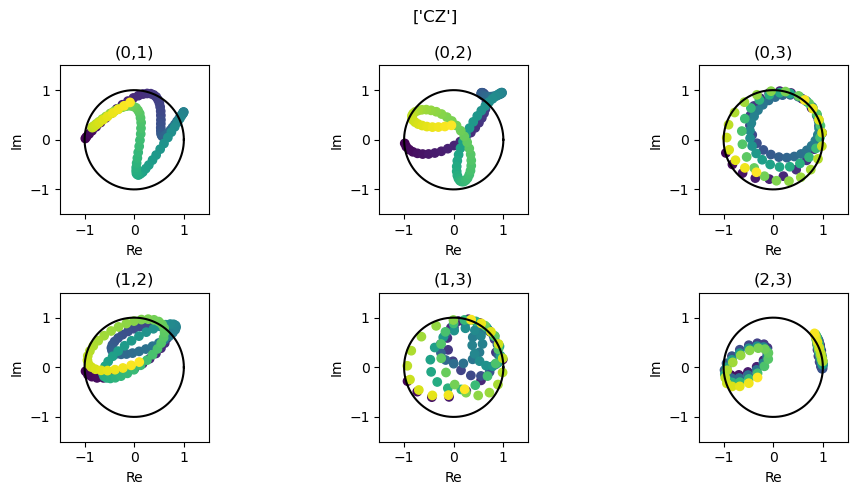

<Figure size 640x480 with 0 Axes>

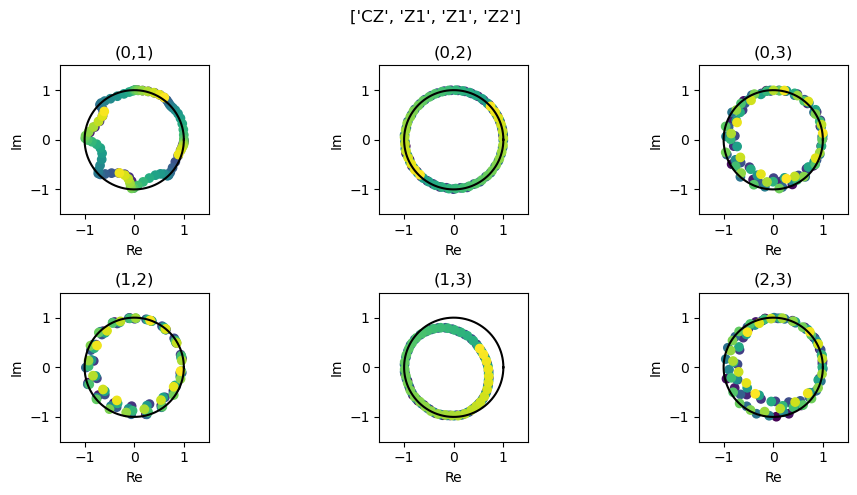

<Figure size 640x480 with 0 Axes>

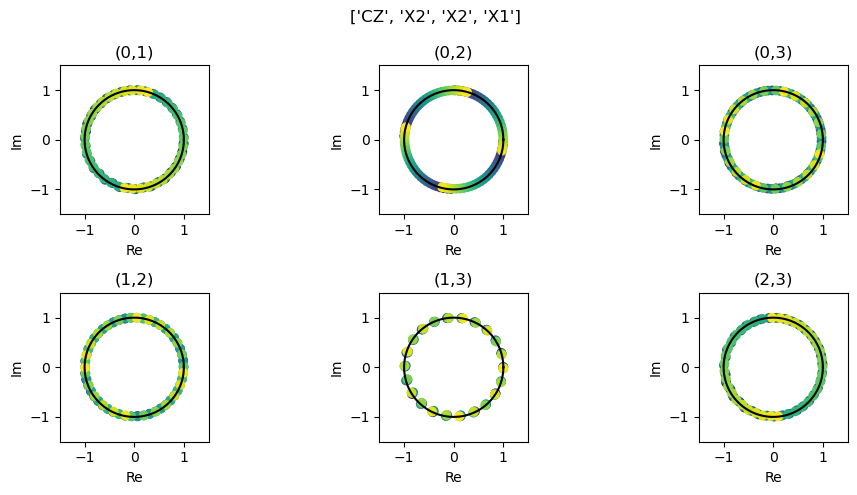

<Figure size 640x480 with 0 Axes>

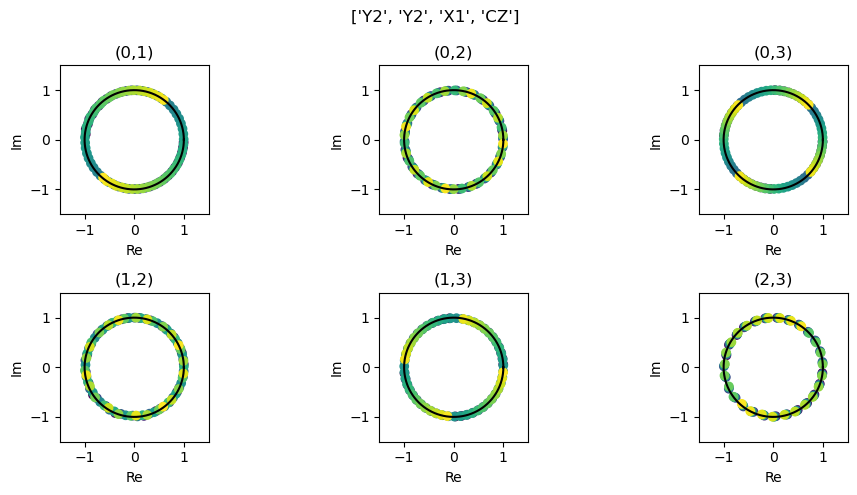

<Figure size 640x480 with 0 Axes>

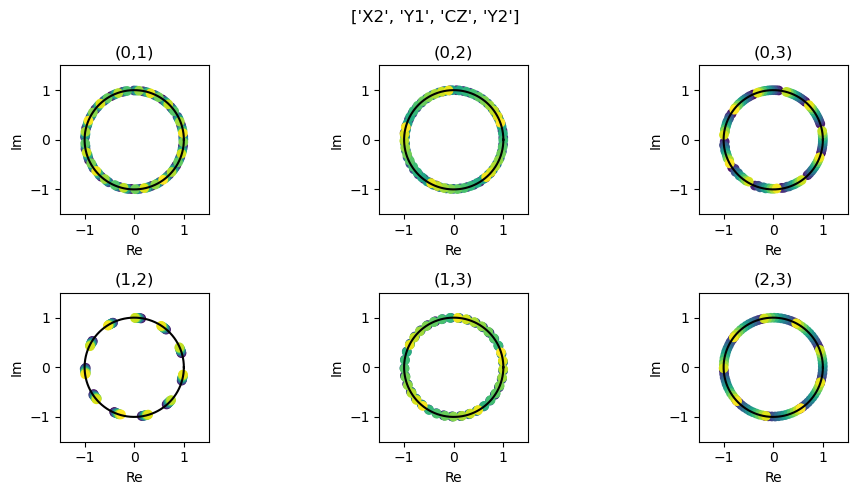

<Figure size 640x480 with 0 Axes>

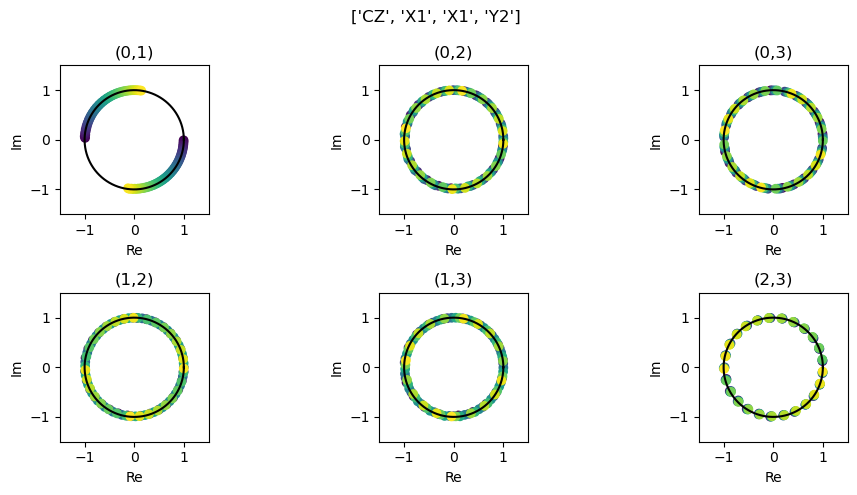

<Figure size 640x480 with 0 Axes>

In [413]:

germs = [['CZ'],
         ['CZ', 'Z1', 'Z1', 'Z2'], 
         ['CZ', 'X2', 'X2', 'X1'],
         ['Y2', 'Y2', 'X1', 'CZ'],
         ['X2', 'Y1', 'CZ', 'Y2'],
         ['CZ', 'X1', 'X1', 'Y2']]
depths = [i+1 for i in range(100)]
edesign = RPEDesign(UnitaryGateSetModel_CZOnly(), germs, depths)
x = 0.1*np.random.randn(15)

# bar plot x 
plt.bar(np.arange(15), x)


for germ in germs: 
    plot_cartan_signals(edesign, germ, x)
    plt.show()
    plt.figure()

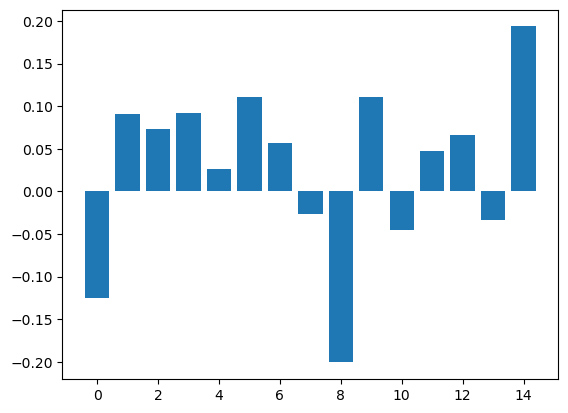

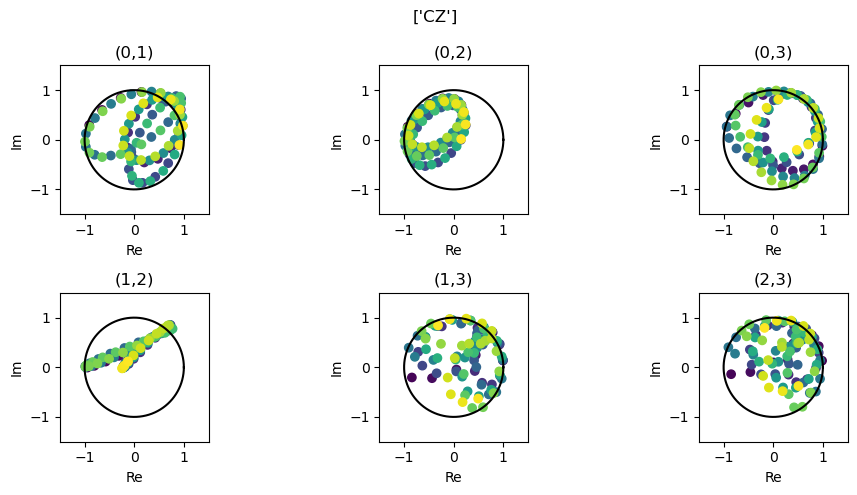

<Figure size 640x480 with 0 Axes>

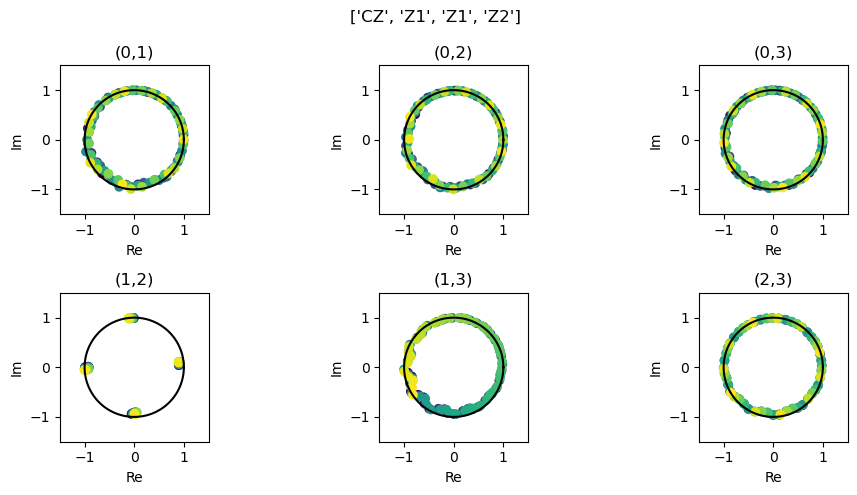

<Figure size 640x480 with 0 Axes>

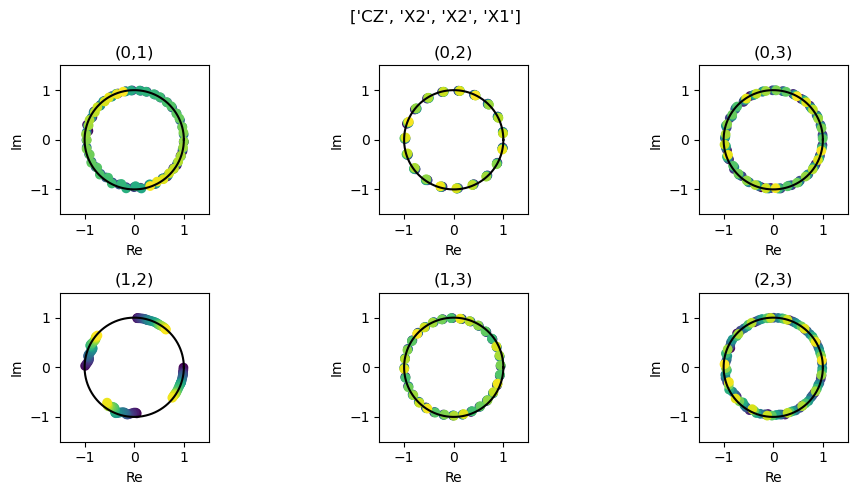

<Figure size 640x480 with 0 Axes>

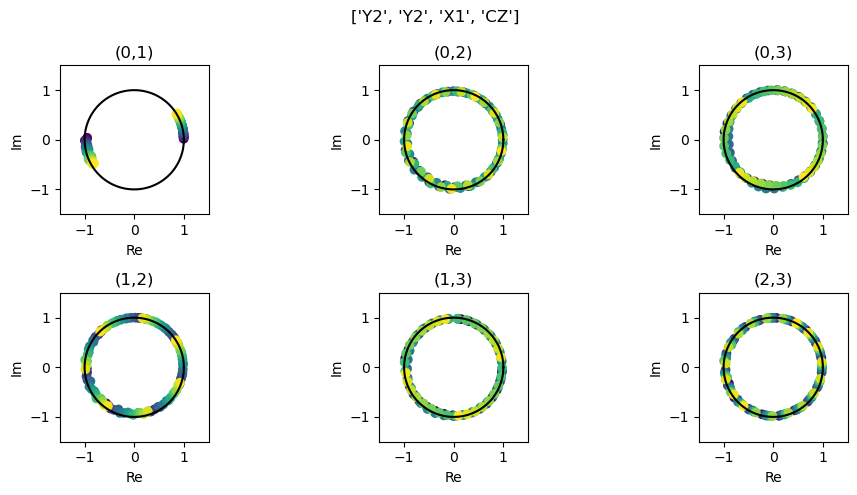

<Figure size 640x480 with 0 Axes>

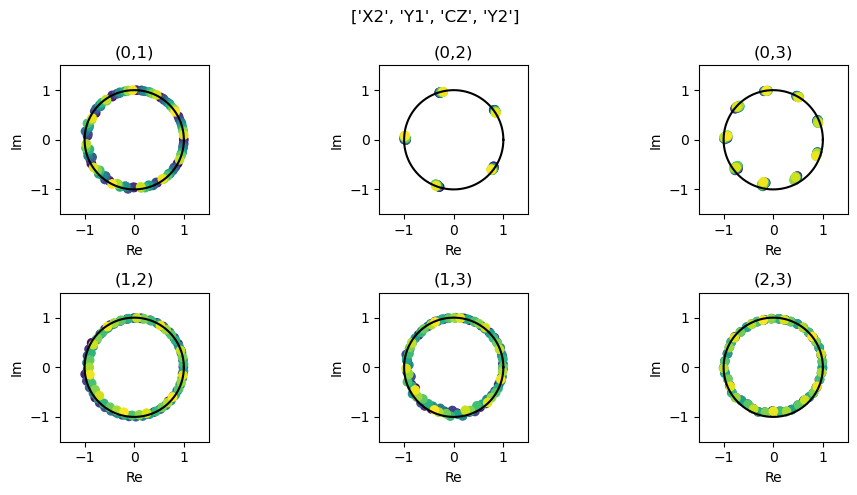

<Figure size 640x480 with 0 Axes>

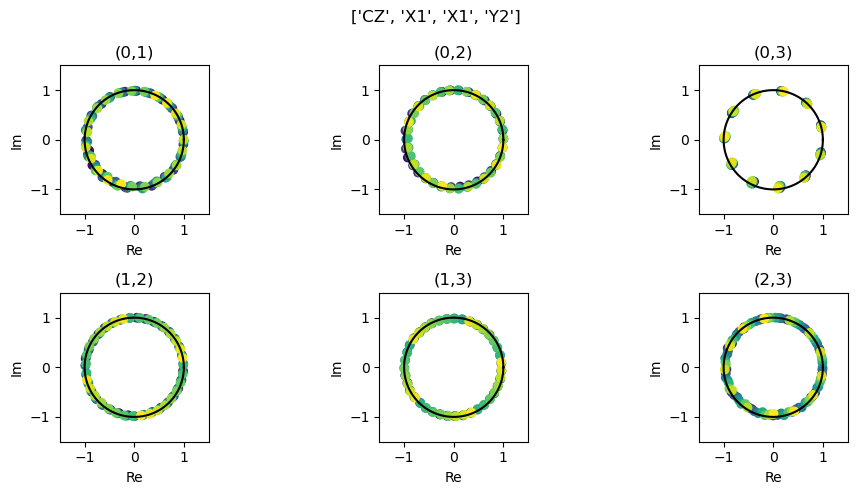

<Figure size 640x480 with 0 Axes>

In [414]:

germs = [['CZ'],
         ['CZ', 'Z1', 'Z1', 'Z2'], 
         ['CZ', 'X2', 'X2', 'X1'],
         ['Y2', 'Y2', 'X1', 'CZ'],
         ['X2', 'Y1', 'CZ', 'Y2'],
         ['CZ', 'X1', 'X1', 'Y2']]
depths = [i+1 for i in range(100)]
edesign = RPEDesign(UnitaryGateSetModel_CZOnly(), germs, depths)
x = 0.1*np.random.randn(15)

# bar plot x 
plt.bar(np.arange(15), x)


for germ in germs: 
    plot_cartan_signals(edesign, germ, x)
    plt.show()
    plt.figure()

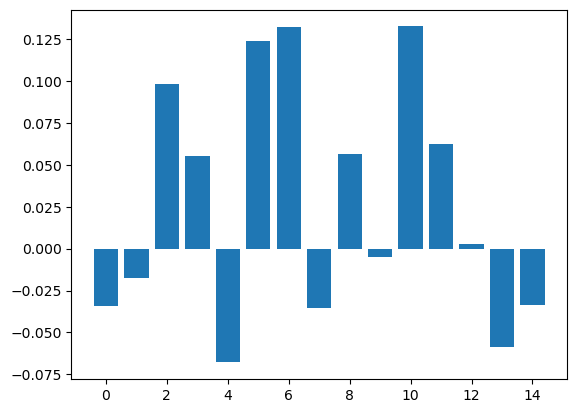

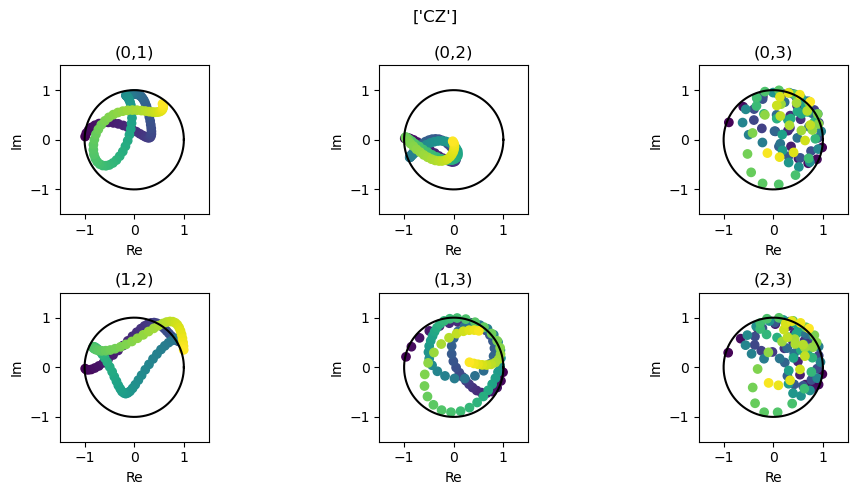

<Figure size 640x480 with 0 Axes>

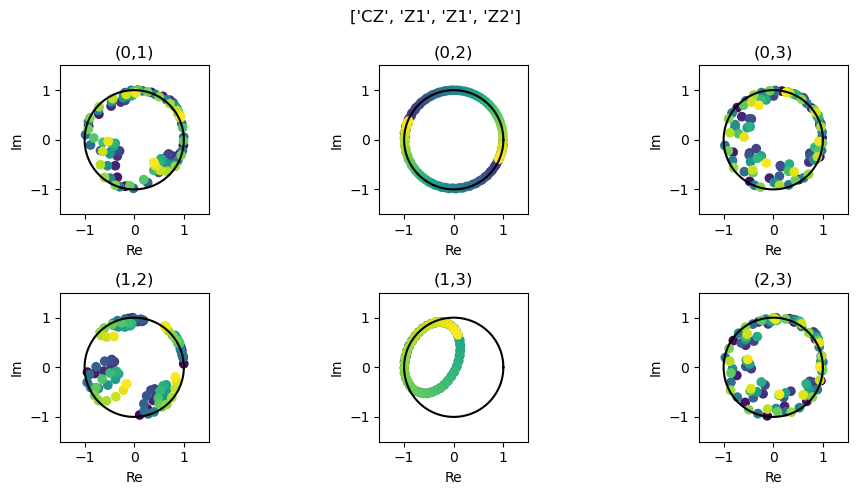

<Figure size 640x480 with 0 Axes>

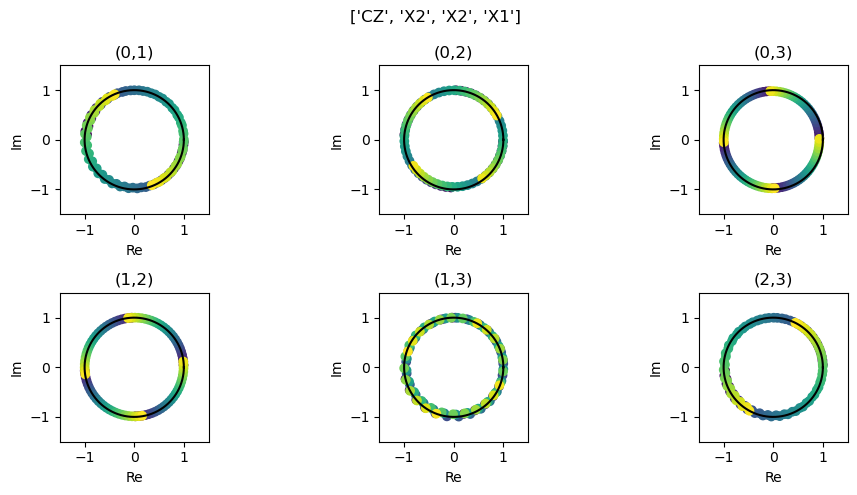

<Figure size 640x480 with 0 Axes>

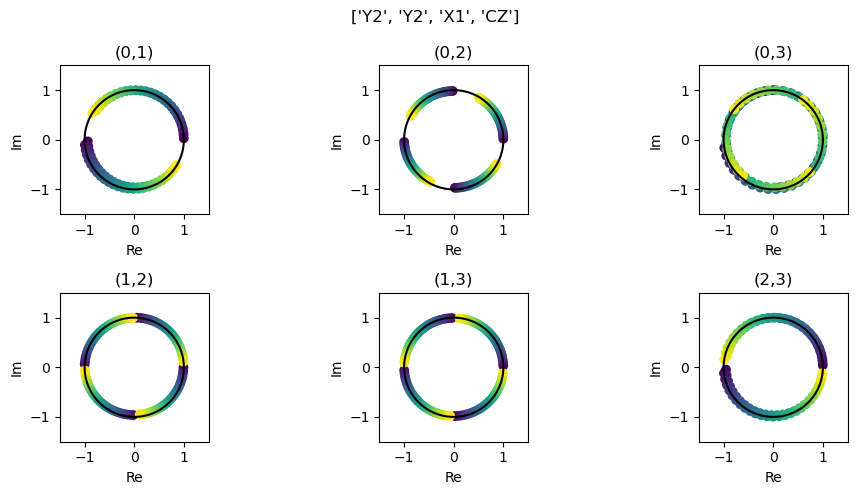

<Figure size 640x480 with 0 Axes>

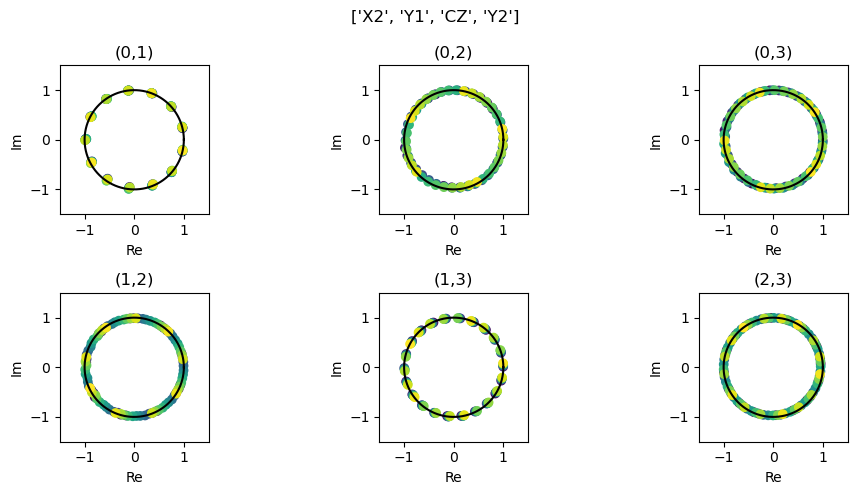

<Figure size 640x480 with 0 Axes>

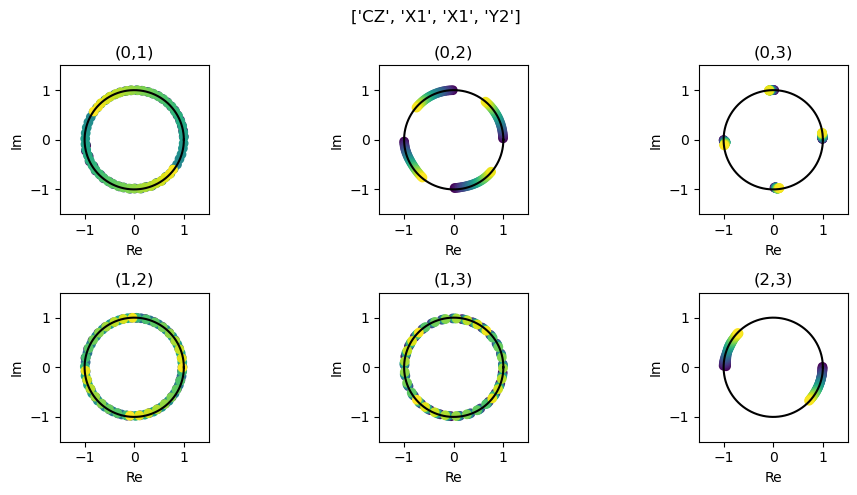

<Figure size 640x480 with 0 Axes>

In [415]:

germs = [['CZ'],
         ['CZ', 'Z1', 'Z1', 'Z2'], 
         ['CZ', 'X2', 'X2', 'X1'],
         ['Y2', 'Y2', 'X1', 'CZ'],
         ['X2', 'Y1', 'CZ', 'Y2'],
         ['CZ', 'X1', 'X1', 'Y2']]
depths = [i+1 for i in range(100)]
edesign = RPEDesign(UnitaryGateSetModel_CZOnly(), germs, depths)
x = 0.1*np.random.randn(15)

# bar plot x 
plt.bar(np.arange(15), x)


for germ in germs: 
    plot_cartan_signals(edesign, germ, x)
    plt.show()
    plt.figure()

In [417]:
from scipy.optimize import minimize

In [465]:
def model_cexp(depth, decay, phase):
    return np.exp(-depth*(decay + 1j*phase))

def cost_function(depth, decay, phase, signal):
    # the signal is complex 
    model_signal = model_cexp(depth, decay, phase)
    return np.linalg.norm(np.abs(model_signal - signal)**2)

def estimate_complex_exp(signal, depths, x0=0):
    res = minimize(lambda x: cost_function(depths, 0, x, signal), x0, method='Nelder-Mead')
    return res.x


In [467]:
signal = edesign.signal(germs[4], x, (0, 3))
depths = np.array(edesign.depths)
phase = estimate_complex_exp(signal, depths)
print(phase)

[0.01925]


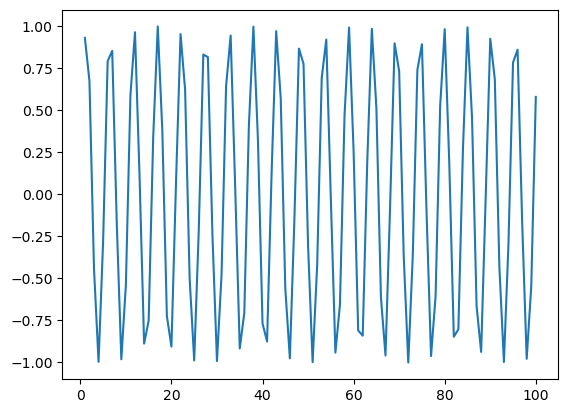

In [481]:
plt.plot(depths, model_cexp(depths, 0, -1.2).imag, label='data')

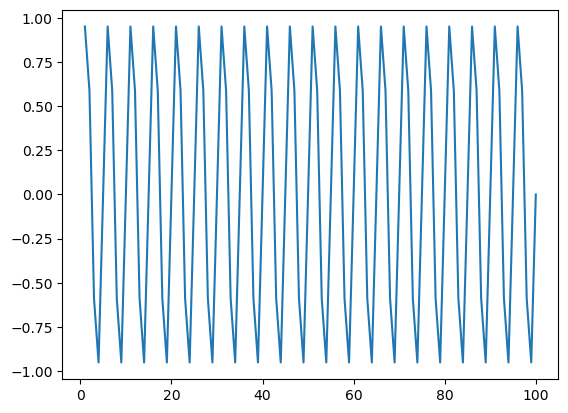

In [473]:
plt.plot(depths, np.imag(signal), label='data')

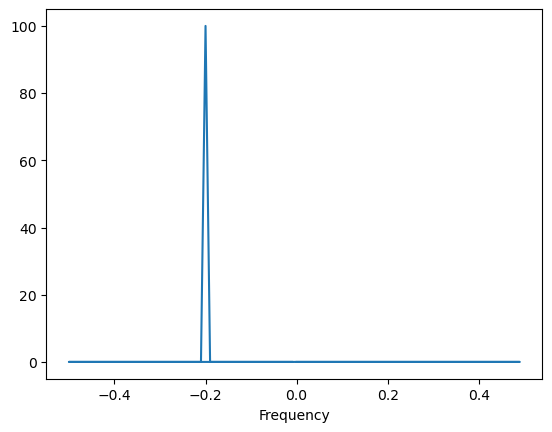

In [469]:
# take the FFT of the signal
fft_signal = np.fft.fft(signal)
# plot the spectrum with the angles on the x axis

plt.xlabel('Frequency')
# recover the frequencies from the FFT
frequencies = np.fft.fftfreq(len(signal))
plt.plot(frequencies, np.abs(fft_signal))